In [1]:
# https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87
# ORG qwk, 30 epochs: 0.86788
# qwk: 0.858779 ( best for 10 epochs) lr = 3e-4
# qwk: 0.834941 ( best for 10 epochs) lr = 3e-5
# qwk: 0.85099 ( best for 10 epochs) lr = 3e-4, kappa_loss
# qwk: 0.86618 ( best for 10 epochs) lr = 3e-4, BCE + kappa_loss

In [2]:
import os
import sys

In [3]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import math
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
import gc

In [4]:
DEBUG=False
data_dir = '../data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'effnet_b1_script4b_c1'

enet_type = 'efficientnet-b1'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 25
batch_size = 2
num_workers = 4
out_dim = 5
out_dim1 = 3
out_dim2 = 3
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 15
n_epochs = 10 if DEBUG else 30
# df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

../data/train_images


In [5]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,4
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [6]:
df_train.isup_grade.nunique()

6

In [7]:
df_train.isup_grade.value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

In [8]:
df_train.gleason_score.value_counts()

3+3         2666
0+0         1925
3+4         1342
4+3         1243
4+4         1126
negative     967
4+5          849
5+4          248
5+5          127
3+5           80
5+3           43
Name: gleason_score, dtype: int64

In [9]:
gleason_isup_mapping = {
    '3+3': 1,
    '3+4': 2,
    '0+0': 0,
    '4+3': 3,
    '4+4': 4,
    '3+5': 4,
    '5+3': 4,
    '4+5': 5,
    '5+4': 5,
    '5+5': 5,
    'negative': 0
}

In [10]:
gl_map = {
    '0':0,
    '3':1,
    '4':2,
    '5':3
}

In [11]:
df_train['gl1'] = df_train['gleason_score'].map(lambda x: x.split('+')[0] if x != 'negative' else '0')
df_train['gl1'] = df_train['gl1'].map(lambda x: gl_map[x])

df_train['gl2'] = df_train['gleason_score'].map(lambda x: x.split('+')[1] if x != 'negative' else '0')
df_train['gl2'] = df_train['gl2'].map(lambda x: gl_map[x])

In [12]:
df_train['gl1'].value_counts()

1    4088
2    3218
0    2892
3     418
Name: gl1, dtype: int64

In [13]:
df_train['gl2'].value_counts()

1    3952
0    2892
2    2716
3    1056
Name: gl2, dtype: int64

In [14]:
1925 + 967

2892

In [15]:
df_train.fold.value_counts()

0    2126
1    2125
2    2123
3    2122
4    2120
Name: fold, dtype: int64

In [16]:
from numba import jit
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

In [17]:
# https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [18]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

In [19]:
# https://www.kaggle.com/hmendonca/kaggle-pytorch-utility-script
def cont_kappa(input, targets, activation=torch.sigmoid):
    ''' continuos version of quadratic weighted kappa '''
    n = len(targets)
    y = targets.float().unsqueeze(0)
    pred = input.float().squeeze(-1).unsqueeze(0)
    if activation is not None:
        pred = activation(pred)
    wo = (pred - y)**2
    we = (pred - y.t())**2
    return 1 - (n * wo.sum() / we.sum())

kappa_loss = lambda pred, y: 1 - cont_kappa(pred, y) 

In [20]:
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [21]:
# https://github.com/ai-med/squeeze_and_excitation/blob/master/squeeze_and_excitation/squeeze_and_excitation.py
"""
Squeeze and Excitation Module
*****************************
Collection of squeeze and excitation classes where each can be inserted as a block into a neural network architechture
    1. `Channel Squeeze and Excitation <https://arxiv.org/abs/1709.01507>`_
    2. `Spatial Squeeze and Excitation <https://arxiv.org/abs/1803.02579>`_
    3. `Channel and Spatial Squeeze and Excitation <https://arxiv.org/abs/1803.02579>`_
"""

from enum import Enum

import torch
import torch.nn as nn
import torch.nn.functional as F


class ChannelSELayer(nn.Module):
    """
    Re-implementation of Squeeze-and-Excitation (SE) block described in:
        *Hu et al., Squeeze-and-Excitation Networks, arXiv:1709.01507*
    """

    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSELayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output tensor
        """
        batch_size, num_channels, H, W = input_tensor.size()
        # Average along each channel
        squeeze_tensor = input_tensor.view(batch_size, num_channels, -1).mean(dim=2)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        a, b = squeeze_tensor.size()
        output_tensor = torch.mul(input_tensor, fc_out_2.view(a, b, 1, 1))
        return output_tensor

In [22]:
class SpatialSELayer(nn.Module):
    """
    Re-implementation of SE block -- squeezing spatially and exciting channel-wise described in:
        *Roy et al., Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks, MICCAI 2018*
    """

    def __init__(self, num_channels):
        """
        :param num_channels: No of input channels
        """
        super(SpatialSELayer, self).__init__()
        self.conv = nn.Conv2d(num_channels, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, weights=None):
        """
        :param weights: weights for few shot learning
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output_tensor
        """
        # spatial squeeze
        batch_size, channel, a, b = input_tensor.size()

        if weights is not None:
            weights = torch.mean(weights, dim=0)
            weights = weights.view(1, channel, 1, 1)
            out = F.conv2d(input_tensor, weights)
        else:
            out = self.conv(input_tensor)
        squeeze_tensor = self.sigmoid(out)

        # spatial excitation
        # print(input_tensor.size(), squeeze_tensor.size())
        squeeze_tensor = squeeze_tensor.view(batch_size, 1, a, b)
        output_tensor = torch.mul(input_tensor, squeeze_tensor)
        #output_tensor = torch.mul(input_tensor, squeeze_tensor)
        return output_tensor

class ChannelSpatialSELayer(nn.Module):
    """
    Re-implementation of concurrent spatial and channel squeeze & excitation:
        *Roy et al., Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks, MICCAI 2018, arXiv:1803.02579*
    """

    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSpatialSELayer, self).__init__()
        self.cSE = ChannelSELayer(num_channels, reduction_ratio)
        self.sSE = SpatialSELayer(num_channels)

    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output_tensor
        """
        output_tensor = torch.max(self.cSE(input_tensor), self.sSE(input_tensor))
        return output_tensor


class SELayer(Enum):
    """
    Enum restricting the type of SE Blockes available. So that type checking can be adding when adding these blockes to
    a neural network::
        if self.se_block_type == se.SELayer.CSE.value:
            self.SELayer = se.ChannelSpatialSELayer(params['num_filters'])
        elif self.se_block_type == se.SELayer.SSE.value:
            self.SELayer = se.SpatialSELayer(params['num_filters'])
        elif self.se_block_type == se.SELayer.CSSE.value:
            self.SELayer = se.ChannelSpatialSELayer(params['num_filters'])
    """
    NONE = 'NONE'
    CSE = 'CSE'
    SSE = 'SSE'
    CSSE = 'CSSE'

In [23]:
# import pretrainedmodels
# model_name='se_resnext50_32x4d'

In [24]:
# base_model

In [25]:
# batch_size = 2
# x = torch.randn(batch_size, 3, 512, 512)

In [26]:
# z = base_model(x)

In [27]:
# z.shape

In [28]:
# enc = nn.Sequential(*list(base_model.children())[:-2])    

In [29]:
# z = enc(x)
# z.shape

In [30]:
# del base_model

In [31]:
# # backbone_model = enet.EfficientNet.from_name('efficientnet-b0')
# # backbone_layers = torch.nn.ModuleList(backbone_model.children())[:-5]
# # features = torch.nn.Sequential(*backbone_layers)
# class seresnext50v2(nn.Module):
#     def __init__(self, backbone, out_dim):
#         super(seresnext50v2, self).__init__()
#         self.base_model = pretrainedmodels.__dict__[backbone](pretrained='imagenet')
#         self.enc = nn.Sequential(*list(self.base_model.children())[:-1])    
# #         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
# #         self.backbone_layers = torch.nn.ModuleList(self.enet.children())[:-5]
# #         self.features = nn.Sequential(*self.backbone_layers)
# #         self.features = nn.Sequential(*list(self.enet.children())[:-5])
# #         self.base_model.avg_pool = nn.Identity()
# #         self.base_model.last_linear = nn.Identity()
# #         self.sse = SpatialSELayer(2048)
#         self.conv = nn.Conv2d(2048, 64, 1)
#         self.flatten = nn.Flatten()
# #         nc = self.flatten.shape[0] * self.flatten.shape[1]
#         self.mymodel = nn.Sequential(
#             nn.Linear(64 * 34 * 34,1024),
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, out_dim))
# #         self.sSE = SpatialSELayer(1024)
# # #         self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
# #         self.myfc1 = nn.Linear(1024, 512)
# # #         self.relu1 = nn.ReLU()
# #         self.dropout = nn.Dropout(0.5)
# #         self.myfc = nn.Linear(1024, out_dim)
# #         self.enet._fc = nn.Identity()

#     def extract(self, x):
#         return self.enc(x)
# #         return self.features(x)

#     def forward(self, x):
#         x = self.enc(x)
# #         print(x.shape)
# #         x = self.sse(x)
#         x = self.conv(x)
# #         print(x.shape)
#         x = self.flatten(x)
# #         print(x.shape)
# #         x = x.view(1, -1)
# #         print(x.shape)
#         x = self.mymodel(x)
#         return x

In [32]:
# model = seresnext50v2(model_name, out_dim)

In [33]:
# z = model(x)

In [34]:
# z.shape

In [35]:
# del model
# gc.collect()

In [36]:
pretrained_model = {
    'efficientnet-b1': '/home/watts/.torch/models/efficientnet-b1-dbc7070a.pth'
}

In [37]:
# backbone_model = enet.EfficientNet.from_name('efficientnet-b0')
# backbone_layers = torch.nn.ModuleList(backbone_model.children())[:-5]
# # features = torch.nn.Sequential(*backbone_layers)
# meta = torch.nn.Sequential(*backbone_layers, SpatialSELayer(1024),
#                                   nn.Linear(1024, 512),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=0.2),
#                                   nn.Linear(512, out_dim))

In [38]:
# meta

In [39]:
# backbone_model

In [40]:
# features

In [41]:
sigmoid = torch.nn.Sigmoid()
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

swish_layer = Swish_module()

def relu_fn(x):
    """ Swish activation function """
    return swish_layer(x)


In [42]:
class DenseCrossEntropy(nn.Module):
    def forward(self, x, target, reduction='mean'):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        if reduction == 'mean':
            return loss.mean()
        elif reduction == 'sum':
            return loss.sum()
        elif reduction == 'none':
            return loss

In [43]:
class ArcFaceLoss(nn.modules.Module):
    def __init__(self, s=30.0, m=0.5, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        self.s = s
        self.cos_m = math.cos(m)             #  0.87758
        self.sin_m = math.sin(m)             #  0.47943
        self.th = math.cos(math.pi - m)      # -0.87758
        self.mm = math.sin(math.pi - m) * m  #  0.23971

    def forward(self, logits, labels):
        logits = logits.float()  # float16 to float32 (if used float16)
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))  # equals to **2
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss = DenseCrossEntropy()(output, labels, self.reduction)
        return loss / 2


In [44]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine


In [45]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc1 = nn.Linear(self.enet._fc.in_features, out_dim1)
        self.myfc2 = nn.Linear(self.enet._fc.in_features, out_dim2)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x1 = self.myfc1(x)
        x2 = self.myfc2(x)
        return x1, x2

In [46]:
# class enetv2(nn.Module):

#     def __init__(self, backbone, out_dim):
#         super(enetv2, self).__init__()
#         self.enet = enet.EfficientNet.from_name(backbone)
#         self.enet.load_state_dict(torch.load(pretrained_model[backbone]), strict=True)
#         self.dropouts = nn.ModuleList([
#             nn.Dropout(0.5) for _ in range(5)
#         ])

#         self.gfc = nn.Linear(self.enet._fc.in_features, 4096)
#         self.metric_classify = ArcMarginProduct(4096, out_dim)
#         self.myfc_1 = nn.Linear(4096, out_dim)
# #         self.myfc_2_1 = nn.Linear(4096, 512)
# #         self.myfc_2_2 = nn.Linear(512, out_dim_2)
#         self.enet._fc = nn.Identity()

#     def extract(self, x):
#         return self.enet(x)

#     def forward(self, x):
#         x = self.extract(x)
#         x = Swish_module()(self.gfc(x))
#         for i, dropout in enumerate(self.dropouts):
#             if i == 0:
#                 out_1 = self.myfc_1(dropout(x))
                
#             else:
#                 out_1 += self.myfc_1(dropout(x))
#         out_1 /= len(self.dropouts)
#         metric_output = self.metric_classify(x)
#         return out_1, metric_output

In [47]:
# backbone_model = enet.EfficientNet.from_name('efficientnet-b0')
# backbone_layers = torch.nn.ModuleList(backbone_model.children())[:-5]
# features = torch.nn.Sequential(*backbone_layers)
# class enetv2(nn.Module):
#     def __init__(self, backbone, out_dim):
#         super(enetv2, self).__init__()
#         self.enet = enet.EfficientNet.from_name(backbone)
#         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
# #         self.backbone_layers = torch.nn.ModuleList(self.enet.children())[:-5]
# #         self.features = nn.Sequential(*self.backbone_layers)
# #         self.features = nn.Sequential(*list(self.enet.children())[:-5])
#         self.enet._fc = nn.Identity()
#         self.enet._dropout = nn.Identity()
#         self.enet._avg_pooling = nn.Identity()
#         self.enet._bn1 = nn.Identity()
#         self.enet._conv_head = nn.Identity()
#         self.mymodel = nn.Sequential(
#             SpatialSELayer(1280),
#             nn.Linear(1280, 512),
#             nn.ReLU(True),
#             nn.Dropout(p=0.2),
#             nn.Linear(512, out_dim))
# #         self.sSE = SpatialSELayer(1024)
# # #         self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
# #         self.myfc1 = nn.Linear(1024, 512)
# # #         self.relu1 = nn.ReLU()
# #         self.dropout = nn.Dropout(0.5)
# #         self.myfc = nn.Linear(1024, out_dim)
# #         self.enet._fc = nn.Identity()

#     def extract(self, x):
#         return self.enet(x)
# #         return self.features(x)

#     def forward(self, x):
#         x = self.enet(x)
#         print(x.shape)
#         x = self.mymodel(x)
#         return x

In [48]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


In [49]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
#         print(tiff_file)
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
            
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label1 = np.zeros(3).astype(np.float32)
        label1[:row.gl1] = 1.
        label2 = np.zeros(3).astype(np.float32)
        label2[:row.gl2] = 1.
        return torch.tensor(images), torch.tensor(label1), torch.tensor(label2)

In [50]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

In [51]:
# tiff_file = "../data/train_images/984505f6a79b889bed5897d2135b85b1.tiff"
# image = skimage.io.MultiImage(tiff_file)[1]

In [52]:
# image[-1]

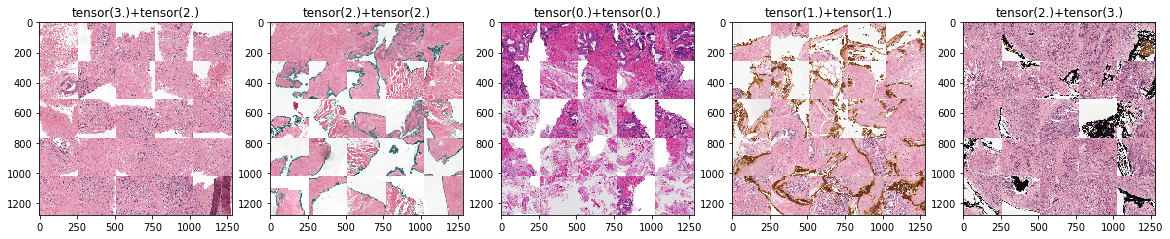

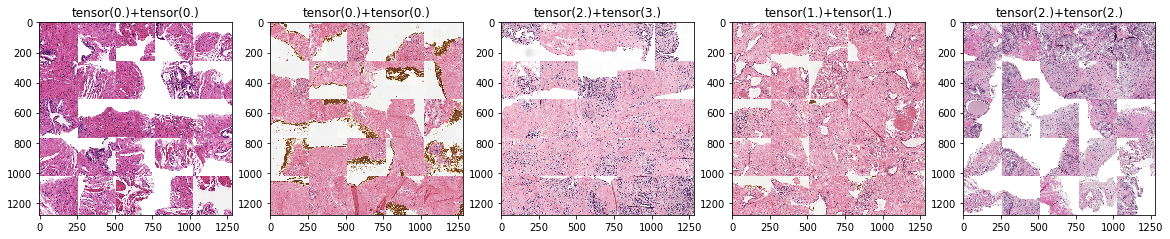

In [53]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label1, label2 = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label1))+'+'+str(sum(label2)))

In [54]:
# criterion = nn.BCEWithLogitsLoss()

In [55]:
# loss_weight = [4, 2, 1, 1, 2]
loss_weight = [4, 2]
# c0_dim = 1295

In [56]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

In [57]:
# def criterion(logits_1, metric_logits, target, loss_weight=loss_weight, is_val=False):

# #     loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
# #     loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
# #     loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]

# #     if is_val:
# #         loss = (loss_1 + loss_2 + loss_3) / sum(loss_weight[1:4])
# #     else:
    

# #     loss_0 = nn.BCEWithLogitsLoss()(logits_1, target) * loss_weight[0]
# #     loss_metric = ArcFaceLoss()(metric_logits, target.float()) * loss_weight[1]
# #     loss = (loss_0 + loss_metric) / sum(loss_weight)
# #     loss = nn.BCEWithLogitsLoss()(logits_1, target)
# #     loss = nn.CrossEntropyLoss()(logits_1, target)
# #     loss = kappa_loss(logits_1, target)
# #     logits_1 = logits_1.cpu().detach().numpy()
# #     PREDS = torch.cat(PREDS).cpu().numpy()
# #     target = target.cpu().detach().numpy()
# #     print(logits_1.shape)
# #     print(target.shape)
#     loss1 = nn.BCEWithLogitsLoss()(logits_1, target)
#     logits_1 = logits_1.reshape(-1,)
#     target = target.reshape(-1,)
# #     optR = OptimizedRounder()
# #     optR.fit(logits_1, target)
# #     coefficients = optR.coefficients()
# #     loss = optR._kappa_loss(coefficients, logits_1, target)
#     loss = loss1 + kappa_loss(logits_1, target)
#     return loss

In [58]:
def criterion(logits_1, logits_2, target_1, target_2, is_val=False):

#     loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
#     loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
#     loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]

#     if is_val:
#         loss = (loss_1 + loss_2 + loss_3) / sum(loss_weight[1:4])
#     else:
    

    loss_1 = nn.BCEWithLogitsLoss()(logits_1, target_1) 
    loss_2 = nn.BCEWithLogitsLoss()(logits_2, target_2) 
#     loss_metric = ArcFaceLoss()(metric_logits, target.float()) * loss_weight[1]
#     loss = (loss_0 + loss_metric) / sum(loss_weight)
#     loss = nn.BCEWithLogitsLoss()(logits_1, target)
#     loss = nn.CrossEntropyLoss()(logits_1, target)
#     loss = kappa_loss(logits_1, target)
#     logits_1 = logits_1.cpu().detach().numpy()
#     PREDS = torch.cat(PREDS).cpu().numpy()
#     target = target.cpu().detach().numpy()
#     print(logits_1.shape)
#     print(target.shape)
#     loss1 = nn.BCEWithLogitsLoss()(logits_1, target)
#     fc = FocalLoss()
#     loss1 = fc.forward(logits_1, target)
#     logits_1 = logits_1.reshape(-1,)
#     target = target.reshape(-1,)
#     logits_2 = logits_1.cpu().detach().numpy()
#     target_2 = target.cpu().detach().numpy()
#     optR = OptimizedRounder()
#     optR.fit(logits_2, target_2)
#     coefficients = optR.coefficients()
#     pred1 = np.array(optR.predict(logits_2, coefficients))
# #     print(pred1)
#     device = torch.device("cuda")
#     pred1 = torch.tensor(pred1, requires_grad=True, dtype=torch.float, device=device)
#     loss = nn.BCEWithLogitsLoss()(pred1, target)
#     loss = optR._kappa_loss(coefficients, logits_1, target)
#     loss = loss1 + kappa_loss(logits_1, target)
    loss = loss_1 + loss_2
    return loss

In [59]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target1, target2) in bar:
        
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
        loss_func = criterion
        optimizer.zero_grad()
#         print(data.shape, target.shape)
        logits1, logits2 = model(data)
        loss = loss_func(logits1, logits2, target1, target2)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss

In [60]:
def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS1 = []
    PREDS1 = []
    TARGETS1 = []

    LOGITS2 = []
    PREDS2 = []
    TARGETS2 = []
    with torch.no_grad():
        for (data, target1, target2) in tqdm(loader):
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
            logits1, logits2 = model(data)

            loss = criterion(logits1, logits2, target1, target2)

            pred1 = logits1.sigmoid().sum(1).detach().round()
            pred2 = logits2.sigmoid().sum(1).detach().round()
            LOGITS1.append(logits1)
            PREDS1.append(pred1)
            TARGETS1.append(target1.sum(1))

            LOGITS2.append(logits2)
            PREDS2.append(pred2)
            TARGETS2.append(target2.sum(1))
            
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS1 = torch.cat(LOGITS1).cpu().numpy()
    PREDS1 = torch.cat(PREDS1).cpu().numpy()
    TARGETS1 = torch.cat(TARGETS1).cpu().numpy()
    LOGITS2 = torch.cat(LOGITS2).cpu().numpy()
    PREDS2 = torch.cat(PREDS2).cpu().numpy()
    TARGETS2 = torch.cat(TARGETS2).cpu().numpy()
    acc1 = (PREDS1 == TARGETS1).mean() * 100.
    acc2 = (PREDS2 == TARGETS2).mean() * 100.
    acc = (acc1 + acc2)/2.
    
    qwk1 = cohen_kappa_score(PREDS1, TARGETS1, weights='quadratic')
    qwk2 = cohen_kappa_score(PREDS2, TARGETS2, weights='quadratic')
    qwk = (qwk1 + qwk2)/2.
    qwk_k1 = cohen_kappa_score(PREDS1[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].gl1.values, weights='quadratic')
    qwk_r1 = cohen_kappa_score(PREDS1[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].gl1.values, weights='quadratic')
    
    qwk_k2 = cohen_kappa_score(PREDS2[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].gl2.values, weights='quadratic')
    qwk_r2 = cohen_kappa_score(PREDS2[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].gl2.values, weights='quadratic')
    
    qwk_k = (qwk_k1 + qwk_k2)/2.
    qwk_r = (qwk_r1 + qwk_r2)/2.
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [61]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8490 2126


In [ ]:
qwk_max = 0.
best_file = f'../cache/{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'../cache/{kernel_type}_final_fold{fold}.pth'))

Tue Jul  7 00:52:18 2020 Epoch: 1


/home/watts/anaconda3/envs/panda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



qwk 0.6756354870990628 qwk_k 0.681828660817051 qwk_r 0.5891440239673317
Tue Jul  7 01:35:39 2020 Epoch 1, lr: 0.0000300, train loss: 0.82278, val loss: 0.59504, acc: 61.33584, qwk: 0.67564
score2 (0.000000 --> 0.675635).  Saving model ...
Tue Jul  7 01:35:39 2020 Epoch: 2



qwk 0.7273094850744182 qwk_k 0.7506418509565257 qwk_r 0.6447816613741885
Tue Jul  7 02:19:14 2020 Epoch 2, lr: 0.0000480, train loss: 0.62671, val loss: 0.51581, acc: 68.10913, qwk: 0.72731
score2 (0.675635 --> 0.727309).  Saving model ...
Tue Jul  7 02:19:14 2020 Epoch: 3



qwk 0.7304246632220407 qwk_k 0.7659997648742494 qwk_r 0.6404023504618277
Tue Jul  7 03:02:48 2020 Epoch 3, lr: 0.0000660, train loss: 0.55113, val loss: 0.51024, acc: 67.30950, qwk: 0.73042
score2 (0.727309 --> 0.730425).  Saving model ...
Tue Jul  7 03:02:48 2020 Epoch: 4



qwk 0.7613026513334942 qwk_k 0.8008544832137829 qwk_r 0.6742284703579839
Tue Jul  7 03:46:21 2020 Epoch 4, lr: 0.0000840, train loss: 0.51538, val loss: 0.49678, acc: 69.37912, qwk: 0.76130
score2 (0.730425 --> 0.761303).  Saving model ...
Tue Jul  7 03:46:21 2020 Epoch: 5



qwk 0.7560390254581901 qwk_k 0.8076428856068104 qwk_r 0.666308406146768
Tue Jul  7 04:29:55 2020 Epoch 5, lr: 0.0001020, train loss: 0.50080, val loss: 0.48512, acc: 70.60207, qwk: 0.75604
Tue Jul  7 04:29:55 2020 Epoch: 6



qwk 0.6891401299127792 qwk_k 0.7364720304922927 qwk_r 0.5973912393005774
Tue Jul  7 05:13:26 2020 Epoch 6, lr: 0.0001200, train loss: 0.48718, val loss: 0.53459, acc: 68.29727, qwk: 0.68914
Tue Jul  7 05:13:26 2020 Epoch: 7



qwk 0.7336217953211841 qwk_k 0.7966093535771308 qwk_r 0.6194690163639716
Tue Jul  7 05:56:59 2020 Epoch 7, lr: 0.0001380, train loss: 0.47222, val loss: 0.53560, acc: 69.00282, qwk: 0.73362
Tue Jul  7 05:56:59 2020 Epoch: 8



qwk 0.759480477223967 qwk_k 0.8024153549355807 qwk_r 0.6685860356200387
Tue Jul  7 06:40:34 2020 Epoch 8, lr: 0.0001560, train loss: 0.46126, val loss: 0.50497, acc: 68.32079, qwk: 0.75948
Tue Jul  7 06:40:34 2020 Epoch: 9



qwk 0.7306187474729915 qwk_k 0.7784026579782486 qwk_r 0.6426914957739318
Tue Jul  7 07:24:12 2020 Epoch 9, lr: 0.0001740, train loss: 0.45434, val loss: 0.51035, acc: 69.99059, qwk: 0.73062
Tue Jul  7 07:24:12 2020 Epoch: 10



qwk 0.7691423243469263 qwk_k 0.8154348788389161 qwk_r 0.670973129508435
Tue Jul  7 08:07:48 2020 Epoch 10, lr: 0.0001920, train loss: 0.45770, val loss: 0.47805, acc: 70.01411, qwk: 0.76914
score2 (0.761303 --> 0.769142).  Saving model ...
Tue Jul  7 08:07:48 2020 Epoch: 11



qwk 0.7632257102447193 qwk_k 0.8009761873033785 qwk_r 0.6767768940053764
Tue Jul  7 08:51:23 2020 Epoch 11, lr: 0.0002100, train loss: 0.45093, val loss: 0.49012, acc: 69.92004, qwk: 0.76323
Tue Jul  7 08:51:23 2020 Epoch: 12



qwk 0.792766079687581 qwk_k 0.82028399848336 qwk_r 0.7299719580554838
Tue Jul  7 09:34:55 2020 Epoch 12, lr: 0.0002280, train loss: 0.44400, val loss: 0.48063, acc: 72.50706, qwk: 0.79277
score2 (0.769142 --> 0.792766).  Saving model ...
Tue Jul  7 09:34:55 2020 Epoch: 13



qwk 0.7578411821699034 qwk_k 0.7946072425636341 qwk_r 0.6761305766404486
Tue Jul  7 10:18:24 2020 Epoch 13, lr: 0.0002460, train loss: 0.44003, val loss: 0.47876, acc: 72.60113, qwk: 0.75784
Tue Jul  7 10:18:24 2020 Epoch: 14



qwk 0.7733008518286507 qwk_k 0.8152955235302308 qwk_r 0.6883650821508849
Tue Jul  7 11:02:35 2020 Epoch 14, lr: 0.0002640, train loss: 0.44487, val loss: 0.52436, acc: 70.15522, qwk: 0.77330
Tue Jul  7 11:02:35 2020 Epoch: 15



qwk 0.7488560916215024 qwk_k 0.7769691217684388 qwk_r 0.669971734369559
Tue Jul  7 11:47:06 2020 Epoch 15, lr: 0.0002820, train loss: 0.43665, val loss: 0.50565, acc: 69.87300, qwk: 0.74886
Tue Jul  7 11:47:06 2020 Epoch: 16



qwk 0.7534177299646663 qwk_k 0.7977890499062101 qwk_r 0.6779363148165818
Tue Jul  7 12:31:31 2020 Epoch 16, lr: 0.0003000, train loss: 0.43631, val loss: 0.51031, acc: 72.20132, qwk: 0.75342
Tue Jul  7 12:31:31 2020 Epoch: 17



qwk 0.7911428096249651 qwk_k 0.8259492983420823 qwk_r 0.7200563161973075
Tue Jul  7 13:16:09 2020 Epoch 17, lr: 0.0000300, train loss: 0.37232, val loss: 0.44859, acc: 73.58890, qwk: 0.79114
Tue Jul  7 13:16:09 2020 Epoch: 18



qwk 0.7622986722895488 qwk_k 0.7998834604762517 qwk_r 0.6916908851627046
Tue Jul  7 14:00:10 2020 Epoch 18, lr: 0.0002870, train loss: 0.42417, val loss: 0.50185, acc: 72.48354, qwk: 0.76230
Tue Jul  7 14:00:10 2020 Epoch: 19



qwk 0.7592968391507751 qwk_k 0.8071813162704508 qwk_r 0.6681221014626948
Tue Jul  7 14:44:21 2020 Epoch 19, lr: 0.0002714, train loss: 0.40741, val loss: 0.51670, acc: 72.03669, qwk: 0.75930
Tue Jul  7 14:44:21 2020 Epoch: 20



qwk 0.7820205292354749 qwk_k 0.8071651047889836 qwk_r 0.7144213099266874
Tue Jul  7 15:27:47 2020 Epoch 20, lr: 0.0002504, train loss: 0.39171, val loss: 0.48903, acc: 71.63688, qwk: 0.78202
Tue Jul  7 15:27:47 2020 Epoch: 21



qwk 0.74820181413552 qwk_k 0.8116362889075515 qwk_r 0.656412779475696
Tue Jul  7 16:11:25 2020 Epoch 21, lr: 0.0002250, train loss: 0.37413, val loss: 0.56947, acc: 72.93039, qwk: 0.74820
Tue Jul  7 16:11:25 2020 Epoch: 22



qwk 0.7791501429702592 qwk_k 0.7948046483870321 qwk_r 0.719943641649671
Tue Jul  7 16:55:02 2020 Epoch 22, lr: 0.0001964, train loss: 0.35575, val loss: 0.55537, acc: 70.71966, qwk: 0.77915
Tue Jul  7 16:55:02 2020 Epoch: 23



qwk 0.7871113084844996 qwk_k 0.8401481116177064 qwk_r 0.7039999704768161
Tue Jul  7 17:38:39 2020 Epoch 23, lr: 0.0001657, train loss: 0.34334, val loss: 0.46932, acc: 75.32926, qwk: 0.78711
Tue Jul  7 17:38:39 2020 Epoch: 24



qwk 0.7822965124181238 qwk_k 0.8112858255307995 qwk_r 0.7209835639901532
Tue Jul  7 18:22:11 2020 Epoch 24, lr: 0.0001343, train loss: 0.32065, val loss: 0.47386, acc: 73.61242, qwk: 0.78230
Tue Jul  7 18:22:11 2020 Epoch: 25



qwk 0.8090447747397197 qwk_k 0.8451574593547999 qwk_r 0.7447635535437553
Tue Jul  7 19:05:54 2020 Epoch 25, lr: 0.0001036, train loss: 0.29950, val loss: 0.44394, acc: 76.43462, qwk: 0.80904
score2 (0.792766 --> 0.809045).  Saving model ...
Tue Jul  7 19:05:54 2020 Epoch: 26
